In [1]:
%run -i billiard_defs.py
%run -i gpu_defs.py
from timeit import default_timer as timer

np.set_printoptions(precision=2, suppress=True)
dim = 2
R_particle = 1.0
R_scatter = 10.0
factor = 20.0
system = 'Sinai'
# system = 'Lorentz'

pp_collision_law = PP_SpecularLaw
# pp_collision_law = PP_NoSlipLaw
# pp_collision_law = PP_IgnoreLaw

for pw_collision_law in [PW_NoSlipLaw]:#[PW_SpecularLaw]:#, 
    if system == 'Lorentz':
        R = R_particle + R_scatter
        gap_crit = (2/np.sqrt(3) - 1) * R
        gap = factor * gap_crit
        x0 = R + gap
        y0 = np.sqrt(3) * x0
        wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], pw_collision_law=PW_PeriodicLaw(wrap_dim=0, wrap_wall=1))
                ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], pw_collision_law=PW_PeriodicLaw(wrap_dim=0, wrap_wall=0))
                ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], pw_collision_law=PW_PeriodicLaw(wrap_dim=1, wrap_wall=3))
                ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], pw_collision_law=PW_PeriodicLaw(wrap_dim=1, wrap_wall=2))
                ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, pw_collision_law=pw_collision_law())
                ,SphereWall(dim=dim, base_point=[-x0, -y0], radius=R_scatter, pw_collision_law=pw_collision_law())
                ,SphereWall(dim=dim, base_point=[x0, -y0], radius=R_scatter, pw_collision_law=pw_collision_law())
                ,SphereWall(dim=dim, base_point=[-x0, y0], radius=R_scatter, pw_collision_law=pw_collision_law())
                ,SphereWall(dim=dim, base_point=[x0, y0], radius=R_scatter, pw_collision_law=pw_collision_law())
               ]

    elif system == 'Sinai':
        R = R_particle + R_scatter
        x0 = factor * R
        y0 = x0    
        wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], pw_collision_law=pw_collision_law())
                ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], pw_collision_law=pw_collision_law())
                ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], pw_collision_law=pw_collision_law())
                ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], pw_collision_law=pw_collision_law())
                ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, pw_collision_law=pw_collision_law())
               ]


#     num_part = sqrt_threads_per_block_max**2
#     num_part = 4
    
    k_min = 7
    k_max = 12
    NP = np.arange(0, 2**k_max, 2**k_min) + 2**k_min
#     NP = np.arange(12, 20)
#     NP = [sqrt_threads_per_block_max*10]
    modes = [Particles,Parallel]
#     modes = [Parallel]
#     modes = [Particles]
    run_time = {key:list() for key in modes}
    
    for num_part in NP:
        for mode in modes:
            start = timer()
            print('num part = {}'.format(num_part))

            num_steps = 1000
            max_records = 10
            if (max_records is None) or (max_records is np.inf):
                rec_period = 1
            else:
                rec_period = int(np.ceil(num_steps / max_records))

            rnd = np.random.RandomState(42)
            part = mode(num=num_part, max_steps=num_steps, mass=1, cell_size=[x0, y0], dim=dim, radius= R_particle
                             ,gamma='uniform' , pp_collision_law=pp_collision_law()
                            )

            # set any initial pos, vel, orient, or spin by hand here
#             part.pos_loc[0] = [20,20]
#             part.vel[0] = [0,0]
#             part.pos_loc[1] = [5,20]
#             part.vel[1] = [1,0]
#             part.pos_loc[2] = [35,20]
#             part.vel[2] = [-1,0]
#             part.pos_loc[3] = [0,39.5]
#             part.vel[3] = [0,1]
            
            exec(open("gpu_config.py").read())
            init(wall, part)

            def run():
                for step in range(part.max_steps):
                    next_state(wall, part)
                    if step % rec_period == 0:
                        print('num_part = {}, step = {}'.format(part.num,step))
                        part.record_state()
                        if step > 0:
#                             part.check_sync()
                            check()
                part.clean_up()            
            run()
            elapsed = timer() - start
            print(elapsed)
            run_time[mode].append(elapsed)

num part = 32
in pp cpu
num_part = 32, step = 0
in pp cpu
num_part = 32, step = 1
in pp cpu
num_part = 32, step = 2
in pp cpu
num_part = 32, step = 3
in pp cpu
num_part = 32, step = 4
in pp cpu
num_part = 32, step = 5
in pp cpu
num_part = 32, step = 6
in pp cpu
num_part = 32, step = 7
in pp cpu
num_part = 32, step = 8
in pp cpu
num_part = 32, step = 9
Done!! #Particles = 32, Steps = 10, Time = 54.683130
0.04706746497295073
num part = 32
load_gpu
num_part = 32, step = 0
num_part = 32, step = 1
num_part = 32, step = 2
num_part = 32, step = 3
num_part = 32, step = 4
num_part = 32, step = 5
num_part = 32, step = 6
num_part = 32, step = 7
num_part = 32, step = 8
num_part = 32, step = 9
Done!! #Particles = 32, Steps = 10, Time = 54.683130
1.7335458659446985
num part = 64
in pp cpu
num_part = 64, step = 0
in pp cpu
num_part = 64, step = 1
in pp cpu
num_part = 64, step = 2
in pp cpu
num_part = 64, step = 3
in pp cpu
num_part = 64, step = 4
in pp cpu
num_part = 64, step = 5
in pp cpu
num_part =

In [5]:
run_time

{__main__.Parallel: [29.616846452179487, 237.85533115773],
 __main__.Particles: [44.314553768534324, 296.95333951236796]}

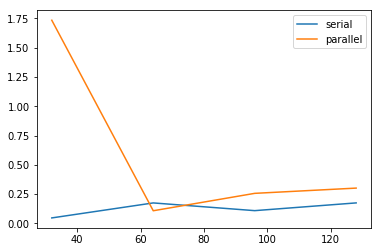

In [2]:
for key, val in run_time.items():
    plt.plot(NP, val, label=key.mode)
plt.legend()
plt.show()